# Instructions

1. Run the cells below and verify that indeed the output is as expected.
2. Trace through the lines and estimate the computational complexity of calculating the mean for
    - the full gaussian process
    - the sparse gaussian process
3. Trace through the lines and estimate the computational complexity of calculating the *covariance* for
    - the full gaussian process
    - the sparse gaussian process
4. (Time permitting) Experiment with different settings for `num_inducing`.

Hints:
 - matrix multiplication of an NxK matrix with a KxM matrix results in an NxM matrix with computational complexity O(NMK)
 - the inverse of a matrix of size M has computational complexity O(M³)
 - for consistency, use N as the number of datapoints, and M as the number of inducing points

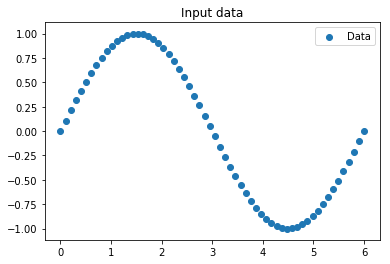

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

x_max = 6
n_full = 60

x_full = np.linspace(0, x_max, n_full).reshape(-1, 1)
y_full = np.sin(x_full / x_max * 2 * np.pi)
sigma = 1e-3

plt.figure()
plt.scatter(x_full, y_full, label='Data')
plt.title('Input data')
plt.legend()


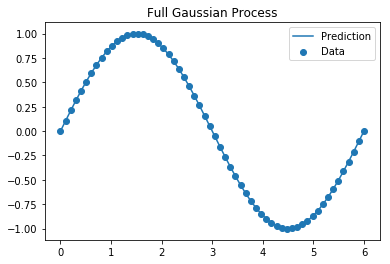

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

ndim = 1
rbf = GPy.kern.RBF(ndim)

x_full = np.linspace(0, x_max, n_full).reshape(-1, 1)
y_full = np.sin(x_full / x_max * 2 * np.pi)
sigma = 1e-3

# O(N^2)
knn = rbf.K(x_full, x_full)

# The full predictions for a Gaussian Process:
# O(N^3)
common = np.linalg.inv((sigma**2) * np.eye(n_full) + knn)

# Complexity: 
# O(N^3) + O(N^2)
mean = np.dot(np.dot(knn, common), y_full)

# O(N^2) + O(N^3) + O(N^3)
covariance = knn - np.dot(np.dot(knn, common), knn)

# print(mean)
# print(covariance)

plt.figure()
plt.scatter(x_full, y_full, label='Data')
plt.plot(x_full, mean, label='Prediction')
plt.title('Full Gaussian Process')
plt.legend()


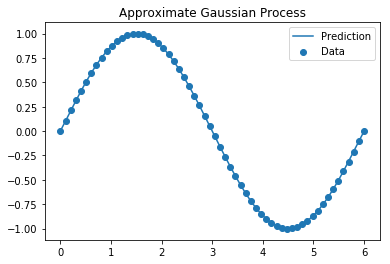

In [4]:
# The predictions for a sparse Gaussian process:
n_inducing = 10
inducing = np.linspace(0, x_max, n_inducing).reshape(-1, 1)

# O(NM)
knm = rbf.K(x_full, inducing)

# O(M^2)
kmm = rbf.K(inducing, inducing)

# O(NM)
kmn = rbf.K(inducing, x_full)

# O(M^3)
kmm_inv = np.linalg.inv(kmm)

# # Show the approximate covariance:
# approximate = np.dot(knm, np.dot(kmm_inv, kmn))
# print(approximate)
# # Now show the full covariance:
# print(knn)

# This is taken directly from the eqations (6) and (10) in the 
# Titsias (2009)

# O(NM^2) + O(M^3)
SIGMA = np.linalg.inv(kmm + (sigma**(-2.0)) * np.dot(kmn, knm))

# O(MN) + O(NM^2) + O(M^3) + O(NM^2) + O(M^3)

# O(NM^2) + O(M^3) sigma
# O(M^3)
# O(NM^2) + O(NM) (kmn)
MU = (1.0 / sigma)**2 * np.dot(np.dot(np.dot(kmm, SIGMA), kmn), y_full)

# O(M^3) + O(NM^2) + O(M^3)
A = np.dot(np.dot(kmm, SIGMA), kmm) #MM
# O(M^3) + O(M^3)
B = np.dot(np.dot(kmm_inv, A), kmm_inv) #MM

# O(NM)  + O(M^3) + O(MN) + O(NM^2) + O(M^3) + O(NM^2) + O(M^3)
mean_induced = np.dot(np.dot(knm, kmm_inv), MU)

# O(NM^2) + O(MN^2) + O(MN^2)
covariance_induced = knn - np.dot(np.dot(knm, kmm_inv), kmn) + np.dot(
    np.dot(knm, B), kmn)

# print(mean_induced)
# print(covariance_induced)

plt.figure()
plt.scatter(x_full, y_full, label='Data')
plt.plot(x_full, mean_induced, label='Prediction')
plt.title('Approximate Gaussian Process')
plt.legend()